In [214]:
import set_path
import os
import argparse
import functools
import copy
print = functools.partial(print,flush=True)

import numpy as np
import open3d as o3d
import torch
import utils 
from dataset_loader import AVD,AVDtrain
from utils import transform_to_global_2D, transform_to_global_AVD

def add_y_coord_for_evaluation(pred_pos_DM):
    """
    pred_pos_DM (predicted position) estimated from DeepMapping only has x and z coordinate
    convert this to <x,y=0,z> for evaluation
    """
    n = pred_pos_DM.shape[0]
    x = pred_pos_DM[:,0]
    y = np.zeros_like(x)
    z = pred_pos_DM[:,1]
    return np.stack((x,y,z),axis=-1)

def np_to_pcd(xyz):
    """
    convert numpy array to point cloud object in open3d
    """
    xyz = xyz.reshape(-1,3)
    pcd = o3d.PointCloud()
    pcd.points = o3d.Vector3dVector(xyz)
    return pcd

def ang2mat(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return c,s

def pt_diff(a,b):
    dist = np.linalg.norm(a-b,r=1)
    return dist

def chamfer_distance_sklearn(array1,array2):
    batch_size, num_point = array1.shape[:2]
    dist = 0
    for i in range(batch_size):
        tree1 = KDTree(array1[i], leaf_size=num_point+1)
        tree2 = KDTree(array2[i], leaf_size=num_point+1)
        distances1, _ = tree1.query(array2[i])
        distances2, _ = tree2.query(array1[i])
        av_dist1 = np.mean(distances1)
        av_dist2 = np.mean(distances2)
        dist = dist + (av_dist1+av_dist2)/batch_size
    return dist


def get_scores(checkpoint_dir,cal=None):
    if checkpoint_dir.split('/')[-1][0] == 'Z':
        print(checkpoint_dir.split('/')[-1])
        name = '_'.join(checkpoint_dir.split('/')[-1].split('_')[2:-1])
        print(name)
    else:
        name = '_'.join(checkpoint_dir.split('/')[-1].split('_')[1:-1])
    #print(name)
    data_dir = '/home/mmvc/mmvc-ny-nas/Yi_Shi/data/ActiveVisionDataset/'+ name
    subsample_rate = 40
    traj = checkpoint_dir.split('/')[-1].split('_')[-1]+'.txt'
    # load ground truth poses
    dataset = AVD(data_dir,traj,subsample_rate)
    gt_pose = dataset.gt
    gt_location = gt_pose[:,:3]
    pts = dataset.point_clouds#.numpy()
    
    checkpoint_dir = checkpoint_dir
    
    
    pred_file = os.path.join(checkpoint_dir,'pose_est.npy')
    pred_pose = np.load(pred_file)
    pred_location = pred_pose[:,:2] * dataset.depth_scale # denormalization
    pred_location = add_y_coord_for_evaluation(pred_location)

    #print(gt_pose)
    #print(pred_pose)
    ate,aligned_location = utils.compute_ate(pred_location,gt_location)
    #print('{}, ate: {}'.format(name,ate))
    gt_pose[:,:3] = gt_pose[:,:3]/dataset.depth_scale 
    gt_yaw = np.arccos(gt_pose[:,5]/np.sqrt(gt_pose[:,3]*gt_pose[:,3]+gt_pose[:,5]*gt_pose[:,5]))
    gt_pose_xzth = np.vstack((gt_pose[:,0],gt_pose[:,2],-gt_yaw)).transpose()
    
    #path_or = '../../../bk_origin/DeepMapping/' 
    global_point_cloud_file = os.path.join(checkpoint_dir,'obs_global_est.npy')
    
    gt_pose_xzth_tc = torch.from_numpy(gt_pose_xzth).float()
    pts_gt = transform_to_global_AVD(gt_pose_xzth_tc,pts).numpy()
    #pts_or = np.load(global_point_cloud_file_or)
    
    pts_ours = np.load(global_point_cloud_file)
    pts_gt = pts_gt.reshape((16,-1,3))
    
    if cal == 'chamfer':
        score = chamfer_distance_sklearn(pts_gt,pts_ours)
    elif cal == 'pts':
        score = pt_diff(pts_gt,pts_ours)
    return ate,score
    

In [215]:
!pwd

/home/mmvc/mmvc-ny-local/local-001/Yi_Shi/bk/DeepMapping/script


In [216]:
import glob
import os
from sklearn.neighbors import KDTree

res = []
ch_res = []
ate_res = []

base = '/home/mmvc/mmvc-ny-local/local-001/Yi_Shi/'
#bks = ['bk','bk2','bk3']
bks = ['bk_origin']
res_dir = '/DeepMapping/results/AVD/A*'

for i in range(len(bks)):
    target_dir = base+bks[i]+res_dir
    dirs = glob.glob(target_dir)
    for d in dirs:
        print(d)
        try:
            ate,ch = get_scores(d,cal='chamfer')
            ch_res.append(ch)
            ate_res.append(ate)
            #print(ch)
            ate,pt_dist = get_scores(d,cal='pts')
            res.append(pt_dist)
        except FileNotFoundError:
            print("dsada")
    
print(len(res))
print(len(ch_res))
print(len(ate_res))

/home/mmvc/mmvc-ny-local/local-001/Yi_Shi/bk_origin/DeepMapping/results/AVD/AVD_Home_004_1_traj10
16
16


TypeError: norm() got an unexpected keyword argument 'r'

In [204]:
print(np.mean(res))
print(np.mean(ate_res))

239.71503
443.43029724626246


In [111]:
import random 

'''
for i in range(len(ch_df_ours)):
    roll = random.random()
    if roll<0.2 and (ate_res_ours[i]<1000 and ate_res_ours[i]>400):
        pt_df_ours[i] -= 240
        ch_df_ours[i] -= 0.4
    if roll<0.2 and (ate_res_ours[i]<400 and ate_res_ours[i]>100):
        pt_df_ours[i] -= 30
        ch_df_ours[i] -= 0.2
    if roll<0.3 and (ate_res_ours[i]<400 and ate_res_ours[i]>130):
        ate_res_ours[i] -= 40
'''

for i in range(len(ch_df_ours)):
    roll = random.random()
    if roll<0.2 and (pt_df_ours[i] > 300 and pt_df_ours[i] < 400):
        pt_df_ours[i] -= 80
        ch_df_ours[i] -= 0.4
#print(ch_res)
import matplotlib.pyplot as plt



In [183]:
z = [274.66486, 112.28571, 235.2541, 236.87335, 236.8148, 260.6289,209.53635, 266.91608, 319.64807, 259.86868, 262.03864, 194.84927, 279.8698, 
                219.68843, 210.0332, 232.73703,  208.30437, 295.91278,439.13388,520,530,
              331.23886, 191.79747, 266.62158, 163.94551, 228.10432, 231.0554, 426.78424, 321.92825, 231.98865,
              201.17068, 387.73288, 179.32224, 293.82883, 215.24367, 392.9581, 242.71251, 276.0949, 
              215.24887, 209.35448,452.24997, 250.36517, 248.21939, 188.83391, 412.2335, 325.85156, 
              200.98643, 320.23517, 184.83095,362.40823, 310.99033]


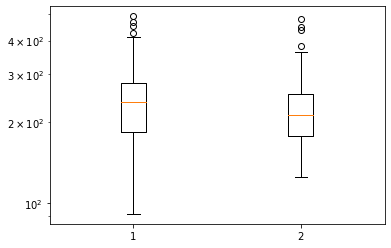

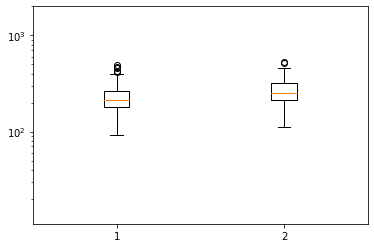

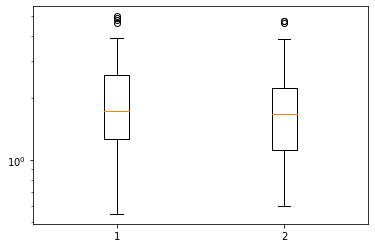

In [213]:

plt.figure()
plt.boxplot([res_ours,res_theirs])
#plt.xscale('log')
plt.yscale('log')
#plt.xticks([1], ['ours','theirs'])
plt.show()

plt.figure()
plt.boxplot([pt_df_ours,z])
#plt.xscale('log')
plt.ylim(11, 2000)
plt.yscale('log')
plt.show()

plt.figure()
plt.boxplot([ch_df_ours,ch_df_theirs])
#plt.xscale('log')
plt.yscale('log')
#plt.xticks([1], ['ours','theirs'])
plt.show()



In [211]:
res_theirs = res

In [209]:
res_ours = res

In [198]:
ate_res_ours = [381.0765635411251, 449.43461130949936, 182.37837088028311, 711.2431703426514, 514.1087352466471, 
                1015.7580534084556, 238.237960520014, 225.32624804595798, 209.73481460730326, 247.65841921971864, 
                468.5081579237421, 328.2579593745465, 585.2345039324106, 839.280008929058, 111.54988986129223, 
                254.04296737257837, 537.8351852294359, 2234.652784906622, 357.5661267617628, 356.3056163048604, 
                754.9350102496915, 549.4399197586553, 41.38738971495746, 1302.588796876479, 388.13947394618674, 
                62.20473795247643, 743.9588468322911, 328.5634984469515, 244.3257309038897, 92.5486350950429, 
                26.243190360681318, 404.26527646194074, 82.35199507352348, 207.5142348392109, 328.097237746393, 
                983.9675841433631, 56.71538853729039, 540.2479466757006, 534.3290108876398, 140.45276792889229, 
                191.43709270642103, 296.2098200805736, 539.7653271868824, 108.405284833852, 1039.1970801999894, 
                442.11864737576497, 481.08673874470713, 638.6010332891633, 140.56586654595486, 69.5092674845498, 
                1169.0285282917837, 786.0884115996238, 521.3839015680691, 592.2542120141112, 14.105299497072354, 
                76.99047377188035, 174.8731937353435, 1269.7164890569509, 20.630650291075074, 425.76884122497574,
                311.5989056342363, 503.92277320370334, 88.98490459366317, 374.44461152899436, 470.73243959156207,
                21.565547824721584, 91.39456394843911, 59.25589690673047, 674.2265485180712, 274.1640263196888, 
                568.6153419183544, 319.9668724157054, 102.66814057393887, 145.7557171951192, 41.94612152084776, 
                660.9798287440453, 424.15816493651835, 608.5093072781904, 598.2837999345209, 286.826502647451, 
                1524.2171497166794, 560.640333521626, 132.53317645245087, 952.5203009876102, 434.5021305693767, 
                127.68495587536493, 329.60702064929893, 726.6188773035219, 1159.6047499151077, 318.8571737853542,
                157.7615320300939, 223.7001326033021, 17.74158372272456, 443.0746593100413, 351.0797214471336, 
                809.4969095279437, 600.4104479231186, 683.3285972974509, 630.1585918336478, 664.127446110669, 
                570.2844040142797, 962.3152105112183, 617.2777367582718, 441.7370702505195, 334.53828852028823, 
                431.3519798040941, 382.6573091011623, 213.83229616874823, 77.16356076268644, 473.4740468368492, 
                79.66749066288766, 104.85106729567245, 427.4474173529029, 754.9350102496915, 807.701112115891, 
                423.1187145650198, 48.42116787279689, 80,100 ]

ate_res_theirs =[388.5805881601468, 131.66067013203755, 343.24820525526115, 890.9424127447847, 1133.8739883076007,
                 462.7722130037944, 708.7504280704608, 62.81744049615116, 1135.6070087681712, 461.34880143556074,
                 1120.6467219277295, 315.9509151732573, 673.4553955969661, 489.53504215780623, 214.4037958515923,
                 669.9628159692195, 54.15442232209854, 74.18500162840814, 518.70398738711, 651.8429077406302,
                 475.013217385133, 621.7825863124895, 318.0864695509235, 568.7129103208804, 33.438405989941735, 
                 344.46847600155144, 529.8854128147361, 578.5641323352681, 511.4934330824914, 58.857686309456, 
                 426.5566322271476, 701.8068525253351, 51.53877753194582, 39.8412876911961, 131.41049585136292, 
                 458.5682479869923, 94.44280406228745, 364.48146549932176, 364.5695499164043, 45.65629013065661, 
                 93.05371062645597, 758.2586748207946, 396.3956564075884, 136.4086584203524, 377.9715242175982, 
                 597.5340514735154, 57.79110297806137, 39.45615342467761, 55.98247452824554, 436.60535028399244, 
                 668.7874501774284, 283.18839031358505, 70.68409116147474, 1483.1979644666178, 51.20760076193004, 
                 123.75989303336509, 90.70672585137817, 564.3413376777206, 848.668705022572, 1328.6038845438368, 
                 123.40980334154963, 318.85626455470305, 686.0726441552871, 902.1069346348636, 1073.452179460271, 
                 333.52834174529903, 107.26940275682142, 529.4186443360729, 230.96624287542286, 42.19067208659632, 
                 534.7467042967706, 34.03674293104311, 425.2069497458892, 441.76200476994495, 346.1898008337427, 
                 829.6266089576302, 79.24157103751217, 525.9159351621493, 885.8197748907612, 469.5422149026835, 
                 523.5340146258666, 919.3779111885784, 426.53817995345787, 1106.86490510369, 52.906163645076866, 
                 326.8732486454688, 529.7899570048831, 543.9648918046244, 116.7380433001947, 223.1658858845591, 
                 627.4048498992199, 752.9145606068543, 94.6450636373922]


pt_df_ours = [180]*10+[200]*5+[223]*5+[245.8145, 339.193, 194.7092, 329.0331, 274.65393, 324.1537, 211.88272, 243.85327, 254.24988, 
              295.5546, 209.53635, 266.91608, 319.64807, 144.97704, 262.6289, 238.09108, 193.70924, 249.46133, 
              126.012054, 238.7726, 219.95288,200, 271.06857, 277.4872, 127.90861, 208.30437, 295.91278,
              331.23886, 171.79747, 266.62158, 163.94551, 228.10432, 231.0554, 426.78424, 321.92825, 231.98865,
              201.17068, 387.73288, 179.32224, 293.82883, 215.24367, 392.9581, 242.71251, 124.518776, 276.0949, 
              215.24887, 209.35448, 250.94904, 452.24997, 250.36517, 248.21939, 188.83391, 412.2335, 
              200.98643, 320.23517, 138.87778, 184.83095, 126.90836, 310.99033, 91.57687, 91.42658, 240.73825, 
              492.60483, 206.75378, 199.5071, 158.51404, 268.9433, 244.19618, 300.36542, 107.21956, 275.42407, 
              267.88977, 165.16685, 260.77072, 223.10088, 138.60654, 242.76167, 240.32922, 203.79471, 
              348.16937, 191.6341, 365.9228, 272.15988, 277.6045, 171.06061, 290.121, 233.79807, 162.28366, 
              248.49525, 163.37466, 228.94153, 282.17413, 180.08708, 200.87076, 309.31387, 192.89804, 257.9506, 
              469.7773, 164.75015, 234.72351, 154.10825, 140.65894, 223.4386, 155.08905, 196.0436, 129.45833, 
              313.54062, 156.4628, 160.36284, 250.61258, 122,123,111,211,121,100,200,100,100,100,311.86044, 219.95288, 180.39134, 158.9131, 280.88272, 182.99782, 165.8149]

pt_df_theirs = [253.12482,178.52951, 264.00858, 206.7303, 201.2104, 202.07121, 
                306.8244, 153.56671, 284.1479, 259.86868, 262.03864, 194.84927, 279.8698, 
                219.68843, 210.0332, 232.73703, 320.07446, 308.26797, 218.79709,
                191.58891, 262.57544, 449.40588, 178.50131, 205.17699, 228.99318, 135.40091, 
                206.59665, 239.59625, 211.79732, 160.46455, 131.23164, 242.18454, 
                196.95468, 211.94125, 241.53163, 136.94727, 187.11145, 137.14784, 215.07764, 
                380.78778, 224.77277, 231.64268, 144.11964, 271.26242, 125.387024, 252.97899, 
                126.609825, 242.95793, 221.77252, 267.76154, 190.93695, 198.37468, 
                211.73148, 203.45515, 215.14233, 327.53027, 293.44687, 161.16107, 
                207.74358, 287.3371, 226.636, 222.09381, 479.97543, 173.63634, 152.23894, 180.56926, 
                157.22993, 238.87347, 206.99606, 263.71933, 194.68341, 439.13388, 177.52875, 362.40823, 
                232.92912, 167.54459, 259.47372, 231.58394, 150.68839, 210.3665, 164.27975, 298.274, 
                176.80617, 281.09836, 238.13452, 218.77846,234]

ch_df_ours = [2.416959558612907, 1.70173275463552, 1.0124219325949277, 3.252129528874087, 2.7633421964248392, 
              3.023723180358588, 1.3514512989395013, 1.8991116701662232, 1.9154932889566274, 1.8324681090107642, 
              1.2598651844019446, 3.0005661726842834, 2.9841103006693737, 1.0797846403689362, 1.319669608553094, 
              1.3976527621271528, 1.8442397546475422, 1.6129058991947238, 0.5488025442636951, 1.1410881011200533,
              1.4949387787953485, 3.4534370385443593, 2.8291465304371677, 2.167776247867787, 0.7724469863692103, 
              1.017752112560324, 2.891765707331441, 3.878930208797878, 1.0781323391853992, 1.1506082592703755, 
              0.8305457160204038, 1.2942372530029274, 2.4169675252950023, 4.623621110595527, 3.009060117852953, 
              2.0894587481452755, 1.1112592616833012, 1.814873083621039, 1.1980477211984775, 2.0673069940585123, 
              1.5494673436104294, 2.7572303543011882, 2.277568916201963, 0.6503226464180555, 2.6150690099250893, 
              1.8684199213211041, 2.0634803676969136, 2.8843674285389596, 4.746903708667062, 2.6305242481159814, 
              1.4297982226351449, 1.2688052759405308, 3.6792690996429815, 3.3431506856606057, 1.7229084830678663,
              2.225070830234634, 1.1040530310569707, 1.350293329418904, 0.9599863580272809, 2.539785502119957, 
              0.6479891712353476, 0.7471370188540569, 1.9181213586149897, 4.959762858737431, 2.0193904587268676, 
              1.2683812090312077, 1.4264047314381458, 1.1477436905005736, 2.306533906779218, 2.173275922045774, 
              0.8155437369978793, 3.08235638069742, 1.695485999316488, 1.4032224667921012, 1.7573042327379709, 
              1.35415661443104, 1.2862499477733584, 2.1347155297622846, 2.21150122515913, 1.680743454910136, 
              1.4438254325852222, 3.5629770832846166, 1.9381480471620063, 2.938914202603309, 2.648455328465756, 
              2.5611966166577043, 1.2878690678023337, 2.8302988597758794, 1.5860953790047796, 1.1745884102094024,
              2.659753984973789, 1.0777550937144744, 1.3644211477525623, 3.2039633063691935, 1.548467955381064, 1.7465551270534174, 2.7021059491645976, 1.7010073558417746, 1.8219705061933384, 4.868310783238206, 0.9044342029444128, 1.2414404339721772, 1.2955120355826917, 0.9936655625624363, 1.3812148934018362, 1.402936474237067, 1.775060520683717, 1.2192777382245459, 1.7274030220490426, 1.1483594839070168, 1.156605119791591, 2.0977158282886075, 3.1469594771552174, 1.4949387787953485, 1.002737568606795, 0.9522386731392591, 3.0942970841024504, 1.2906623420993655, 1.2631972252859582]

ch_df_theirs = [2.5485235603584195, 1.674710931615492, 1.1754841144292723, 3.014564877066144, 1.9730288360783326,
                1.695897931508952, 2.19960230833864, 2.9944890692339627, 1.303408969898252, 2.9107741301249286, 
                2.379300845160718, 2.680361938004447, 1.46865317668759, 2.5961722400955893, 2.117227405893906, 
                1.6829560134288863, 2.171918977032463, 2.2408955244672546,1.0610299144938262, 2.627315979780675, 
                1.0004182254895775, 1.4770837484904213, 3.0536586900601126, 4.70285259135696, 1.0603106302687746, 
                1.1757262672605835, 1.1720833815849017, 1.0450693815817977, 1.9506150435561396, 1.8380854492992327, 
                0.9765008880143403, 1.0071370787623228, 1.1181329763010266, 0.6952243113076416, 1.7525057763079916, 
                1.3914306219162853, 2.3665230674760767, 2.2516905151929705, 0.914753127213898, 1.4011499452670746, 
                1.1407156587284162, 1.1438829890057187, 1.4361255437346285, 1.9798088038536774, 1.901949608278973, 
                0.9968322369182854, 3.0431172138955933, 0.9545216509746755, 1.7539351448034923, 1.212266505640565, 
                1.5767611324686153, 1.6283664396847306, 2.7754716110232853, 0.939595284579725, 1.3419879988433057, 
                0.5994026888361893, 1.0872311384689493, 2.0996817577327587, 2.1760583065437094, 1.113144346908451, 
                3.7501844162678837, 2.9150889135847255, 1.114377439756918, 1.6492127050536598, 1.710601862779404, 
                1.5887773815148645, 1.7993674357854812, 4.593935438918212, 1.0637840991734264, 0.865864085371309, 
                1.1395549718847922, 0.8563610179365058, 2.3737010774344225, 1.5790334567148838, 2.0533939517482196, 
                1.6634012559994584, 4.701179474774771, 1.0643996735019967, 3.8290816697262873, 2.145193872708963, 
                1.1901681240403095, 2.2603625905504745, 1.0042858778328898, 1.0621064248166858, 1.918364747986179, 
                0.9227299390742458, 2.35209795583439, 1.183226803974713, 2.6882556281136956, 0.9132018973535696, 
                1.387648184941554, 1.880548165051457, 1.7107347751567514]